In [ ]:
# Dependencias

!pip install plotly
!pip install cufflinks
!pip install chart_studio
!pip install ipywidgets
!pip install yfinance
!pip install EMD-signal==1.0.0
!pip install sklearn
!pip install keras
!pip install tensorflow

In [ ]:
# imports e definições

from PyEMD import CEEMDAN

import os
import time
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import timedelta, datetime

%matplotlib inline
from scipy.interpolate import CubicSpline

import cufflinks as cf
import chart_studio.plotly as plotly
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=True, world_readable=False)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, LeakyReLU, CuDNNLSTM, Activation
from keras.activations import tanh
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger

import yfinance as yf

from google.colab import drive
from sqlalchemy import create_engine

import IPython

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

class SplineModel():
    def __init__(self):#,time_series_generator):
        self.name = "SplineModel"
        #self.gen = time_series_generator
    
    def predict(self, x_window, days_ahead):   # x_window is the actual x 
        window_size = x_window.shape[1]        # x_window.shape = (1,window_size,5)
        if window_size >= days_ahead:
          # Original SplineModel

          result = []
          x_window = np.squeeze(x_window, axis=0)
          last_element_index = x_window.shape[1]-1
          series = x_window[:,last_element_index].reshape(-1)
          cs = CubicSpline(np.arange(len(series)), series)
          for i in range(days_ahead):
            next_value = cs(len(series) + i + 1)
            result += [next_value]

          return np.array(result).reshape(1,-1)
        
        else:
          # Predicts x_window, then repeats these values to populate days_ahead values
          window_size = 5

          result = []
          prediction = []
          x_window = np.squeeze(x_window, axis=0)
          last_element_index = x_window.shape[1]-1
          series = x_window[:,last_element_index].reshape(-1)
          cs = CubicSpline(np.arange(len(series)), series)
          for i in range(window_size):
            next_value = cs(len(series) + i + 1)
            prediction += [next_value]

          while len(result) < days_ahead:
            for j in range(len(prediction)):
              result.append(prediction[j])

              if len(result) == days_ahead:
                break
              
            break # just predicting the next 5, so as to not overpopulate the results

          return np.array(result).reshape(1,-1)


# convert history into inputs and outputs
def to_multi_step(dataset, n_out):
    X, y = list(), list()
    last_element_index = dataset.shape[1]-1
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(dataset)):
        # define the end of the input sequence
        in_end = in_start
        out_end = in_end + n_out
        
        # ensure we have enough data for this instance
        if out_end <= len(dataset):
            X.append(dataset[in_start, :])
            y.append(dataset[in_end:out_end, last_element_index])
        # move along one time step
        in_start += 1

    return np.array(X), np.array(y)

# Plotting definitions
space =  {
            'legend' : {'bgcolor':'#1A1A1C','font':{'color':'#D9D9D9',"size":12}},
            'paper_bgcolor' : '#1A1A1C',
            'plot_bgcolor' : '#1A1A1C',
            "title" : {"font":{"color":"#D9D9D9"},"x":0.5},
            'yaxis' : {
                'tickfont' : {'color':'#C2C2C2', "size":12},
                'gridcolor' : '#434343',
                'titlefont' : {'color':'#D9D9D9'},
                'zerolinecolor' : '#666570',
                'showgrid' : True
            },
            'xaxis' : {
                'tickfont' : {'color':'#C2C2C2', "size":12},
                'gridcolor' : '#434343',
                'titlefont' : {'color':'#D9D9D9'},
                'zerolinecolor' : '#666570',
                'showgrid' : True
            },
            'titlefont' : {'color':'#D9D9D9'}
        }


# Needed to display results in Colab at least
# From https://stackoverflow.com/questions/52859983/interactive-matplotlib-figures-in-google-colab

def configure_plotly_browser_state():
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

def get_ceemdan(ticker, imf, connection):
  table_name = ticker + '_' + imf
  query = 'SELECT * from ' + table_name

  result = connection.execute(query)
  df = pd.DataFrame(result.fetchall())
  df.columns = result.keys()
  df.set_index('Date', inplace=True)

  return df

def create_directories(stock, imf_level, verbose=False):
  # Assumes that the cell bellow was properly executed

  base_path = '/mymodels'

  stock_dir = f'{base_path}/{stock}/'
  imf_dir = f'{base_path}/{stock}/{imf_level}/'
  checkpoint_dir = f'{base_path}/{stock}/{imf_level}/Checkpoints'

  directories = [stock_dir, imf_dir, checkpoint_dir]

  for path in directories:
    if not os.path.exists(path):
      os.mkdir(path)
      
      if verbose:
        print("Directory " , path ,  " created ")

    elif verbose:
      print("Directory " , path ,  " already exists")


def EWA(input_list):
  # Expects a list
  frame = pd.DataFrame(input_list)
  frame['ewma'] = frame.ewm(span=len(input_list), min_periods=len(input_list), adjust=False).mean()

  inter_list = list(frame['ewma'])

  return inter_list[-1]

def pandas_to_multi_step(dataset, days_ahead, window_size):
    # Expects a pandas dataframe

    index_list = list(dataset.index)

    X, y = list(), list()

    """

      You stored it wrong in the 15_16_17 db
      It is the Adj Close, saved as Close
      Adjust it after the training
      And do it right for the other dbs

    """
    target_feature_index = 'Close'

    index_count = 0
    # step over the entire history one time step at a time
    for _ in range(len(index_list)):
      if index_count + window_size + days_ahead - 1 <= dataset.shape[0] - 1:   # the -1 is to not get the last day as X, since there would be no y available
          # define the end of the input sequence
          in_start = index_list[index_count]
          in_end = index_list[index_count + window_size - 1]

          out_start = index_list[index_count + window_size]
          out_end = index_list[index_count + window_size + days_ahead - 1]
          
          # ensure we have enough data for this item
          X.append(dataset.loc[in_start:in_end, :])
          y.append(dataset.loc[out_start:out_end, target_feature_index])

      elif index_count == 0:
        print(f'Not enough data for days_ahead={days_ahead}')
        return None, None

      # move along one time step
      index_count += 1

    return X, y

In [ ]:
# Google Drive and CEEMDAN decompositions connections

date_range = '15_16_17'

drive.mount('/content/gdrive/')
!ln -s /content/gdrive/Shareddrives/TCC/Implementação/Capitulo3_Treinamento/db /mydbs
!ln -s /content/gdrive/Shareddrives/TCC/Implementação/Capitulo3_Treinamento/models/15_16_17 /mymodels

my_conn = create_engine(f"sqlite:////mydbs/{date_range}.db")

Mounted at /content/gdrive/


In [ ]:
# Getting the data
stocks_list = ['ABEV3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBSE3.SA', 'BRAP4.SA', 'BRFS3.SA', 'BRKM5.SA', 'BRML3.SA', 'BRPR3.SA', 'BRSR6.SA', 'AMER3.SA', 'CCRO3.SA', 'CESP6.SA', 'CIEL3.SA', 'CMIG4.SA', 'CPFE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CSNA3.SA', 'CYRE3.SA', 'DXCO3.SA', 'ECOR3.SA', 'ELET3.SA', 'EMBR3.SA', 'ENBR3.SA', 'EQTL3.SA', 'YDUQ3.SA', 'EVEN3.SA', 'EZTC3.SA', 'FIBR3.SA', 'GFSA3.SA', 'GGBR4.SA', 'GOAU4.SA', 'GOLL4.SA', 'HGTX3.SA', 'HYPE3.SA', 'IGTA3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 'COGN3.SA', 'LAME4.SA', 'LIGT3.SA', 'LREN3.SA', 'MDIA3.SA', 'MGLU3.SA', 'MILS3.SA', 'MMXM3.SA', 'MRFG3.SA', 'MRVE3.SA', 'MULT3.SA', 'ODPV3.SA', 'OIBR3.SA', 'PCAR3.SA', 'PDGR3.SA', 'PETR3.SA', 'POMO4.SA', 'PSSA3.SA', 'ENAT3.SA', 'QUAL3.SA', 'RADL3.SA', 'RAPT4.SA', 'RENT3.SA', 'RSID3.SA', 'SANB3.SA', 'SBSP3.SA', 'SULA11.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIVT3.SA', 'VLID3.SA', 'VVAR11.SA', 'WEGE3.SA' ]
stocks_list = ['RSID3.SA', 'SANB3.SA', 'SBSP3.SA', 'SULA11.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIVT3.SA', 'VLID3.SA', 'VVAR11.SA', 'WEGE3.SA' ]
imf_list = ['IMF1', 'IMF2', 'IMF3', 'IMF4', 'IMF5', 'IMF6', 'IMF7', 'IMF8', 'IMF9', 'IMF10']

target_feature_max_imf_level = {}
db_dataset = {}
for stock in stocks_list:
  stock = stock.replace('.SA', '')
  db_dataset[stock] = {}
  for imf_level in imf_list:
    try:
      db_dataset[stock][imf_level] = get_ceemdan(stock, imf_level, my_conn)

    except:
      print(f'No {imf_level} for {stock}')

      target_feature_max_imf_level[stock] = imf_level
      break

# Converting the data to numpy array
dataset = {}
for key in db_dataset.keys():
  dataset[key] = {}
  for imf in db_dataset[key].keys():
    dataset[key][imf] = db_dataset[key][imf].to_numpy()

No IMF8 for RSID3
No IMF8 for SANB3
No IMF7 for SBSP3
No IMF7 for SULA11
No IMF8 for TAEE11
No IMF7 for TIMS3
No IMF8 for TOTS3
No IMF8 for UGPA3
No IMF8 for USIM5
No IMF7 for VALE3
No IMF8 for VIVT3
No IMF8 for VLID3
No IMF8 for VVAR11
No IMF7 for WEGE3


In [ ]:
train_indexes = {}
val_indexes = {}

train_dataset = {}
val_dataset = {}

date_train_x = {}
date_train_y = {}

days_ahead = 249

max_window_size = 10              
windows_sizes_for_imf_level = {   # These are the number of previous days to predict days_ahead days
    'IMF1': 4,        
    'IMF2': 6,
    'IMF3': 8,
    'IMF4': 8,
    'IMF5': 8,
    'IMF6': 10,
    'IMF7': 10,
    'IMF8': 10,
    'Rsd': 8,
    'DEFAULT': 8
}

for stock in stocks_list:
  stock = stock.replace('.SA', '')
  train_indexes[stock] = {}
  val_indexes[stock] = {}

  train_dataset[stock] = {}
  val_dataset[stock] = {}

  date_train_x[stock] = {}
  date_train_y[stock] = {}

  for imf_level in db_dataset[stock].keys():
    train_indexes[stock][imf_level] = []
    val_indexes[stock][imf_level] = []

    index_list = list(db_dataset[stock][imf_level].index)
    for count, index in enumerate(index_list):
      if '2017' not in index:
        train_indexes[stock][imf_level].append(index)

    train_dataset[stock][imf_level] = db_dataset[stock][imf_level].loc[train_indexes[stock][imf_level][0]:train_indexes[stock][imf_level][-1], :]
    date_train_x[stock][imf_level], date_train_y[stock][imf_level]           = pandas_to_multi_step(train_dataset[stock][imf_level], days_ahead, windows_sizes_for_imf_level[imf_level])

    last_train_x_first_day = date_train_x[stock][imf_level][-1].index[0]      # Each train_x element has 10 days. This is the first day of the last element.

    val_indexes[stock][imf_level] = list(index_list[(index_list.index(last_train_x_first_day) + 1) :])

    val_dataset[stock][imf_level] = db_dataset[stock][imf_level].loc[val_indexes[stock][imf_level][0]:val_indexes[stock][imf_level][-1], :]

In [ ]:
# Pre processing

days_ahead = 249      # Maximum value for our use, in this current case (15-16-17)
batch_size = 1

train_x = {}
train_y = {}
validation_x = {}
validation_y = {}

date_train_x = {}
date_train_y = {}
date_validation_x = {}
date_validation_y = {}

max_window_size = 10              
windows_sizes_for_imf_level = {   # These are the number of previous days to predict days_ahead days
    'IMF1': 4,        
    'IMF2': 6,
    'IMF3': 8,
    'IMF4': 8,
    'IMF5': 8,
    'IMF6': 10,
    'IMF7': 10,
    'IMF8': 10,
    'Rsd': 8,
    'DEFAULT': 8
}

for stock in train_dataset.keys():
  train_x[stock] = {}
  train_y[stock] = {}
  validation_x[stock] = {}
  validation_y[stock] = {}

  date_train_x[stock] = {}
  date_train_y[stock] = {}
  date_validation_x[stock] = {}
  date_validation_y[stock] = {}


  for imf_level in train_dataset[stock].keys():
    if imf_level in windows_sizes_for_imf_level:
      window_size = windows_sizes_for_imf_level[imf_level]
    else:
      window_size = windows_sizes_for_imf_level['DEFAULT']

    date_train_x[stock][imf_level], date_train_y[stock][imf_level]           = pandas_to_multi_step(train_dataset[stock][imf_level], days_ahead, window_size)
    date_validation_x[stock][imf_level], date_validation_y[stock][imf_level] = pandas_to_multi_step(val_dataset[stock][imf_level], days_ahead, window_size)


    while '2017' in date_validation_x[stock][imf_level][-1].index[-1]:      # To remove 2017 from the x validation values
      date_validation_x[stock][imf_level].pop(-1)
      date_validation_y[stock][imf_level].pop(-1)


    train_x[stock][imf_level] = []
    train_y[stock][imf_level] = []

    validation_x[stock][imf_level] = []
    validation_y[stock][imf_level] = []

    for j in range(len(date_train_x[stock][imf_level])):
      # just to make it more readable in a single loop
      #numpy_x = np.expand_dims(date_train_x[stock][imf_level][j].to_numpy(), axis=0) it deals with this in the input apparently
      #numpy_y = np.expand_dims(date_train_y[stock][imf_level][j].to_numpy(), axis=0)    
      numpy_x = date_train_x[stock][imf_level][j]
      numpy_y = date_train_y[stock][imf_level][j]

      train_x[stock][imf_level].append(numpy_x.astype('float32'))   # it was float64, maybe this would help with training time
      train_y[stock][imf_level].append(numpy_y.astype('float32'))

    for j in range(len(date_validation_x[stock][imf_level])):
      # just to make it more readable in a single loop
      #numpy_x = np.expand_dims(date_validation_x[stock][imf_level][j].to_numpy(), axis=0) # since batch is 1, this should suffice
      #numpy_y = np.expand_dims(date_validation_y[stock][imf_level][j].to_numpy(), axis=0) #  but the expanded dimension should have size? equal to the batch size

      numpy_x = date_validation_x[stock][imf_level][j].to_numpy() # since batch is 1, this should suffice
      numpy_y = date_validation_y[stock][imf_level][j].to_numpy() #  but the expanded dimension should have size? equal to the batch size

      validation_x[stock][imf_level].append(numpy_x.astype('float32'))
      validation_y[stock][imf_level].append(numpy_y.astype('float32'))

# Training callbacks


To store all the training data (except the weights themselves)

from tensorflow.keras.callbacks import CSVLogger


csv_file_name = "results.csv"
csv_log = CSVLogger(csv_file_name, separator=',')


To read it later

import pandas as pd
pd.read_csv("results.csv", index_col='epoch')




Save and load History object With Numpy
A history object has a history field, it is a dictionary that holds different training metrics spanned across every training epoch. So e.g. history.history[‘loss’][10] will return a loss of your model in the 10th epoch of training. In order to save that you could pickle this dictionary.

1 np.save('history1.npy',history_const.history)

2 history1=np.load('history1.npy',allow_pickle='TRUE').item()
 

The above code is useful when saving history at the end of the training process. If you want to save the history during the training then use the CSVLogger callback.

In [ ]:
models = {}
history = {}

# Learning rate "reducer"
def lr_decay(epoch, lr):
    if epoch >= 1000 and epoch % 500 == 0:
        return lr * 0.2
    return lr

model_epochs = {
    'IMF1': 2000, # 2500
    'IMF2': 2000, # 2000
    'IMF3': 2000, # 1500
    'IMF4': 1500, # 1500
    'IMF5': 1500,
    'IMF6': 1200,
    'IMF7': 1200,
    'IMF8': 1000,
    'Rsd': 1000,
    'DEFAULT': 1000
}


imfs_to_predict_with_neural = ['IMF1', 'IMF2', 'IMF3']
for stock in train_x:
  models[stock]  = {}
  history[stock] = {}

  reached_max_imf_of_target_feature = False

  for imf_level in train_x[stock]:
    if stock == 'RSID3' and imf_level != 'IMF3':
        pass

    if imf_level in imfs_to_predict_with_neural:
      print(f'Training model [{stock}][{imf_level}]')
      if reached_max_imf_of_target_feature is True:
        break # no need to predict further if target feature doesn't contain greater IMF levels

      if target_feature_max_imf_level[stock] == imf_level:
        reached_max_imf_of_target_feature = True    

      # Prediction model
      model = Sequential()
      n_features = 5 #train_x[stock][imf_level].shape[1] 

      if imf_level in windows_sizes_for_imf_level:
          window_size = windows_sizes_for_imf_level[imf_level]
      else: 
          window_size = windows_sizes_for_imf_level['DEFAULT']

      model.add(CuDNNLSTM(256, return_sequences=True, batch_input_shape=(1, window_size, n_features), stateful=True)) # Original was 128
      model.add(Activation(tanh))
      model.add(CuDNNLSTM(128, input_shape=(window_size, 256), stateful=True)) # Original was 64
      model.add(Activation(tanh))
      model.add(Dense(64))     # Original was 16
      model.add(LeakyReLU())
      model.add(Dense(32))    # Original was 4
      model.add(LeakyReLU())
      model.add(Dense(days_ahead))          # Original was 1
      model.compile(optimizer='adam', loss='mse')

      number_of_epochs = model_epochs[imf_level]

      create_directories(stock, imf_level)      # To create the paths bellow if necessary

      checkpoint_dir = f'/mymodels/{stock}/{imf_level}/Checkpoints/'
      csv_filename = f'/mymodels/{stock}/{imf_level}/csv_history.csv'
      model_filename = f'/mymodels/{stock}/{imf_level}/model.h5'
      history_filename = csv_filename.replace('csv_history.csv', 'history.npy')

      callbacks_list = [LearningRateScheduler(lr_decay, verbose=0),
                       CSVLogger(csv_filename, separator=','),
                       ModelCheckpoint(filepath=checkpoint_dir + '{epoch:02d}-{loss:.5f}.hdf5',
                                       period=1000,
                                       save_weights_only=False,
                                       verbose=1)]


      # fit model
      t0 = time.time()
      cur_history = model.fit(x=np.array(train_x[stock][imf_level]), y=np.array(train_y[stock][imf_level]), 
                              validation_data=(np.array(validation_x[stock][imf_level]), np.array(validation_y[stock][imf_level])),
                              validation_batch_size=1, validation_freq=1000,
                              batch_size=1, epochs=number_of_epochs, verbose=0, shuffle = False, callbacks=callbacks_list)
  

      # Save model and history
      model.save(model_filename)
      np.save(history_filename, cur_history.history)

      t1 = time.time()

      print(f"{stock}-{imf_level} took {t1-t0} seconds to train and save")

      # Need to create, and populate, these dictionaries for the results script
      # Their only use in this script is to check the history or some other minor thing

      models[stock][imf_level] = model
      history[stock][imf_level] = cur_history

    else:
      pass

      """
      # Spline prediction model

      Needs to be trained when it's going to be used (the "training" is basically instantaneous)

      cur_tmp_gen = train_generators[stock][imf_level]
      model = SplineModel(cur_tmp_gen)
      models[stock][imf_level] = model
      """

Training model [RSID3][IMF1]

Epoch 01000: saving model to /mymodels/RSID3/IMF1/Checkpoints/1000-0.00010.hdf5

Epoch 02000: saving model to /mymodels/RSID3/IMF1/Checkpoints/2000-0.00008.hdf5
RSID3-IMF1 took 1335.0886874198914 seconds to train and save
Training model [RSID3][IMF2]

Epoch 01000: saving model to /mymodels/RSID3/IMF2/Checkpoints/1000-0.00007.hdf5

Epoch 02000: saving model to /mymodels/RSID3/IMF2/Checkpoints/2000-0.00002.hdf5
RSID3-IMF2 took 1325.503909111023 seconds to train and save
Training model [RSID3][IMF3]

Epoch 01000: saving model to /mymodels/RSID3/IMF3/Checkpoints/1000-0.00011.hdf5

Epoch 02000: saving model to /mymodels/RSID3/IMF3/Checkpoints/2000-0.00000.hdf5
RSID3-IMF3 took 1309.1579430103302 seconds to train and save
Training model [SANB3][IMF1]

Epoch 01000: saving model to /mymodels/SANB3/IMF1/Checkpoints/1000-0.00005.hdf5

Epoch 02000: saving model to /mymodels/SANB3/IMF1/Checkpoints/2000-0.00004.hdf5
SANB3-IMF1 took 1335.060046195984 seconds to train and

dict_keys(['loss', 'val_loss'])


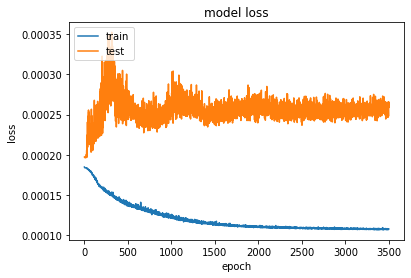

In [ ]:
# Visualize training history
# This is from BBAS3 IMF1

import matplotlib.pyplot as plt

# list all data in history
print(cur_history.history.keys())

# summarize history for loss
plt.plot(cur_history.history['loss'])
plt.plot(cur_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()